In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots;

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 500
quadrature_order       = 5
ϵ                      = 10
t_initial              = minimum(Time)
t_end                  = t_initial+90     # parameter value corresponding to ϵ=0
wind_scale             = 1e-5
wind_center            = 30;
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5()

BS5(true)

In [5]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [6]:
# it would be much easier to write this with interp_rhs and p=UV .+ param.*wind, but that has the wrong type
interp_rhs_scaled = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t))
function T(x,param)
    flow(interp_rhs_scaled, x, [t_initial, t_end]; 
        p=(UV, wind, param), tolerance=solver_tolerance, solver=solver)[end]
end

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

1294.749600 seconds (328.45 M allocations: 19.445 GiB, 0.23% gc time)


In [10]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata);

In [11]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

13971.178924 seconds (96.99 G allocations: 11.556 TiB, 8.93% gc time)


In [12]:
# solve the linear system
@time λ₀s, u₀s = eigs(K, M, which=:SM)
@assert all(imag.(u₀s) .== 0)
@assert all(imag.(λ₀s) .== 0)
u₀s = real.(u₀s)
λ₀s = real.(λ₀s)
# normalize
for i in 1:size(u₀s)[2]
    u₀s[:,i] = u₀s[:,i] ./ sqrt(u₀s[:,i]'*M*u₀s[:,i])
    u₀s[:,i] = u₀s[:,i]*sign(sum(u₀s[:,i]))
end

  5.371224 seconds (9.19 M allocations: 1.041 GiB, 2.10% gc time)


In [13]:
# calculate the exact uϵ
λϵs, uϵs = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵs) .== 0)
@assert all(imag.(λϵs) .== 0)
uϵs = real.(uϵs)
λϵs = real.(λϵs)
# normalize
for i in 1:size(uϵs)[2]
    uϵs[:,i] = uϵs[:,i] ./ sqrt(uϵs[:,i]'*M*uϵs[:,i])
    uϵs[:,i] = uϵs[:,i]*sign(sum(uϵs[:,i]))
end

In [14]:
# solve the system for the derivative u_dot
u_dots = []
λ_dots = []
for i in 1:size(u₀s)[2] 
    lhs = [K-λ₀s[i]*M   -M*u₀s[:,i]
            u₀s[:,i]'*M      0]
    rhs = [-L*u₀s[:,i]    ;  0]

    @time b = lhs \ rhs
    push!(u_dots,b[1:end-1])
    push!(λ_dots,b[end])
end

 21.043536 seconds (2.38 M allocations: 4.071 GiB, 2.05% gc time)
 20.461903 seconds (65.70 k allocations: 3.963 GiB, 0.99% gc time)
  4.757049 seconds (77 allocations: 517.805 MiB)
 19.805871 seconds (82 allocations: 4.083 GiB, 1.09% gc time)
 34.653141 seconds (81 allocations: 5.086 GiB, 0.59% gc time)
 19.658237 seconds (80 allocations: 4.083 GiB, 0.84% gc time)


In [15]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -1
cmax =     1
cmin_lr =  -1000
cmax_lr =  1000

1000

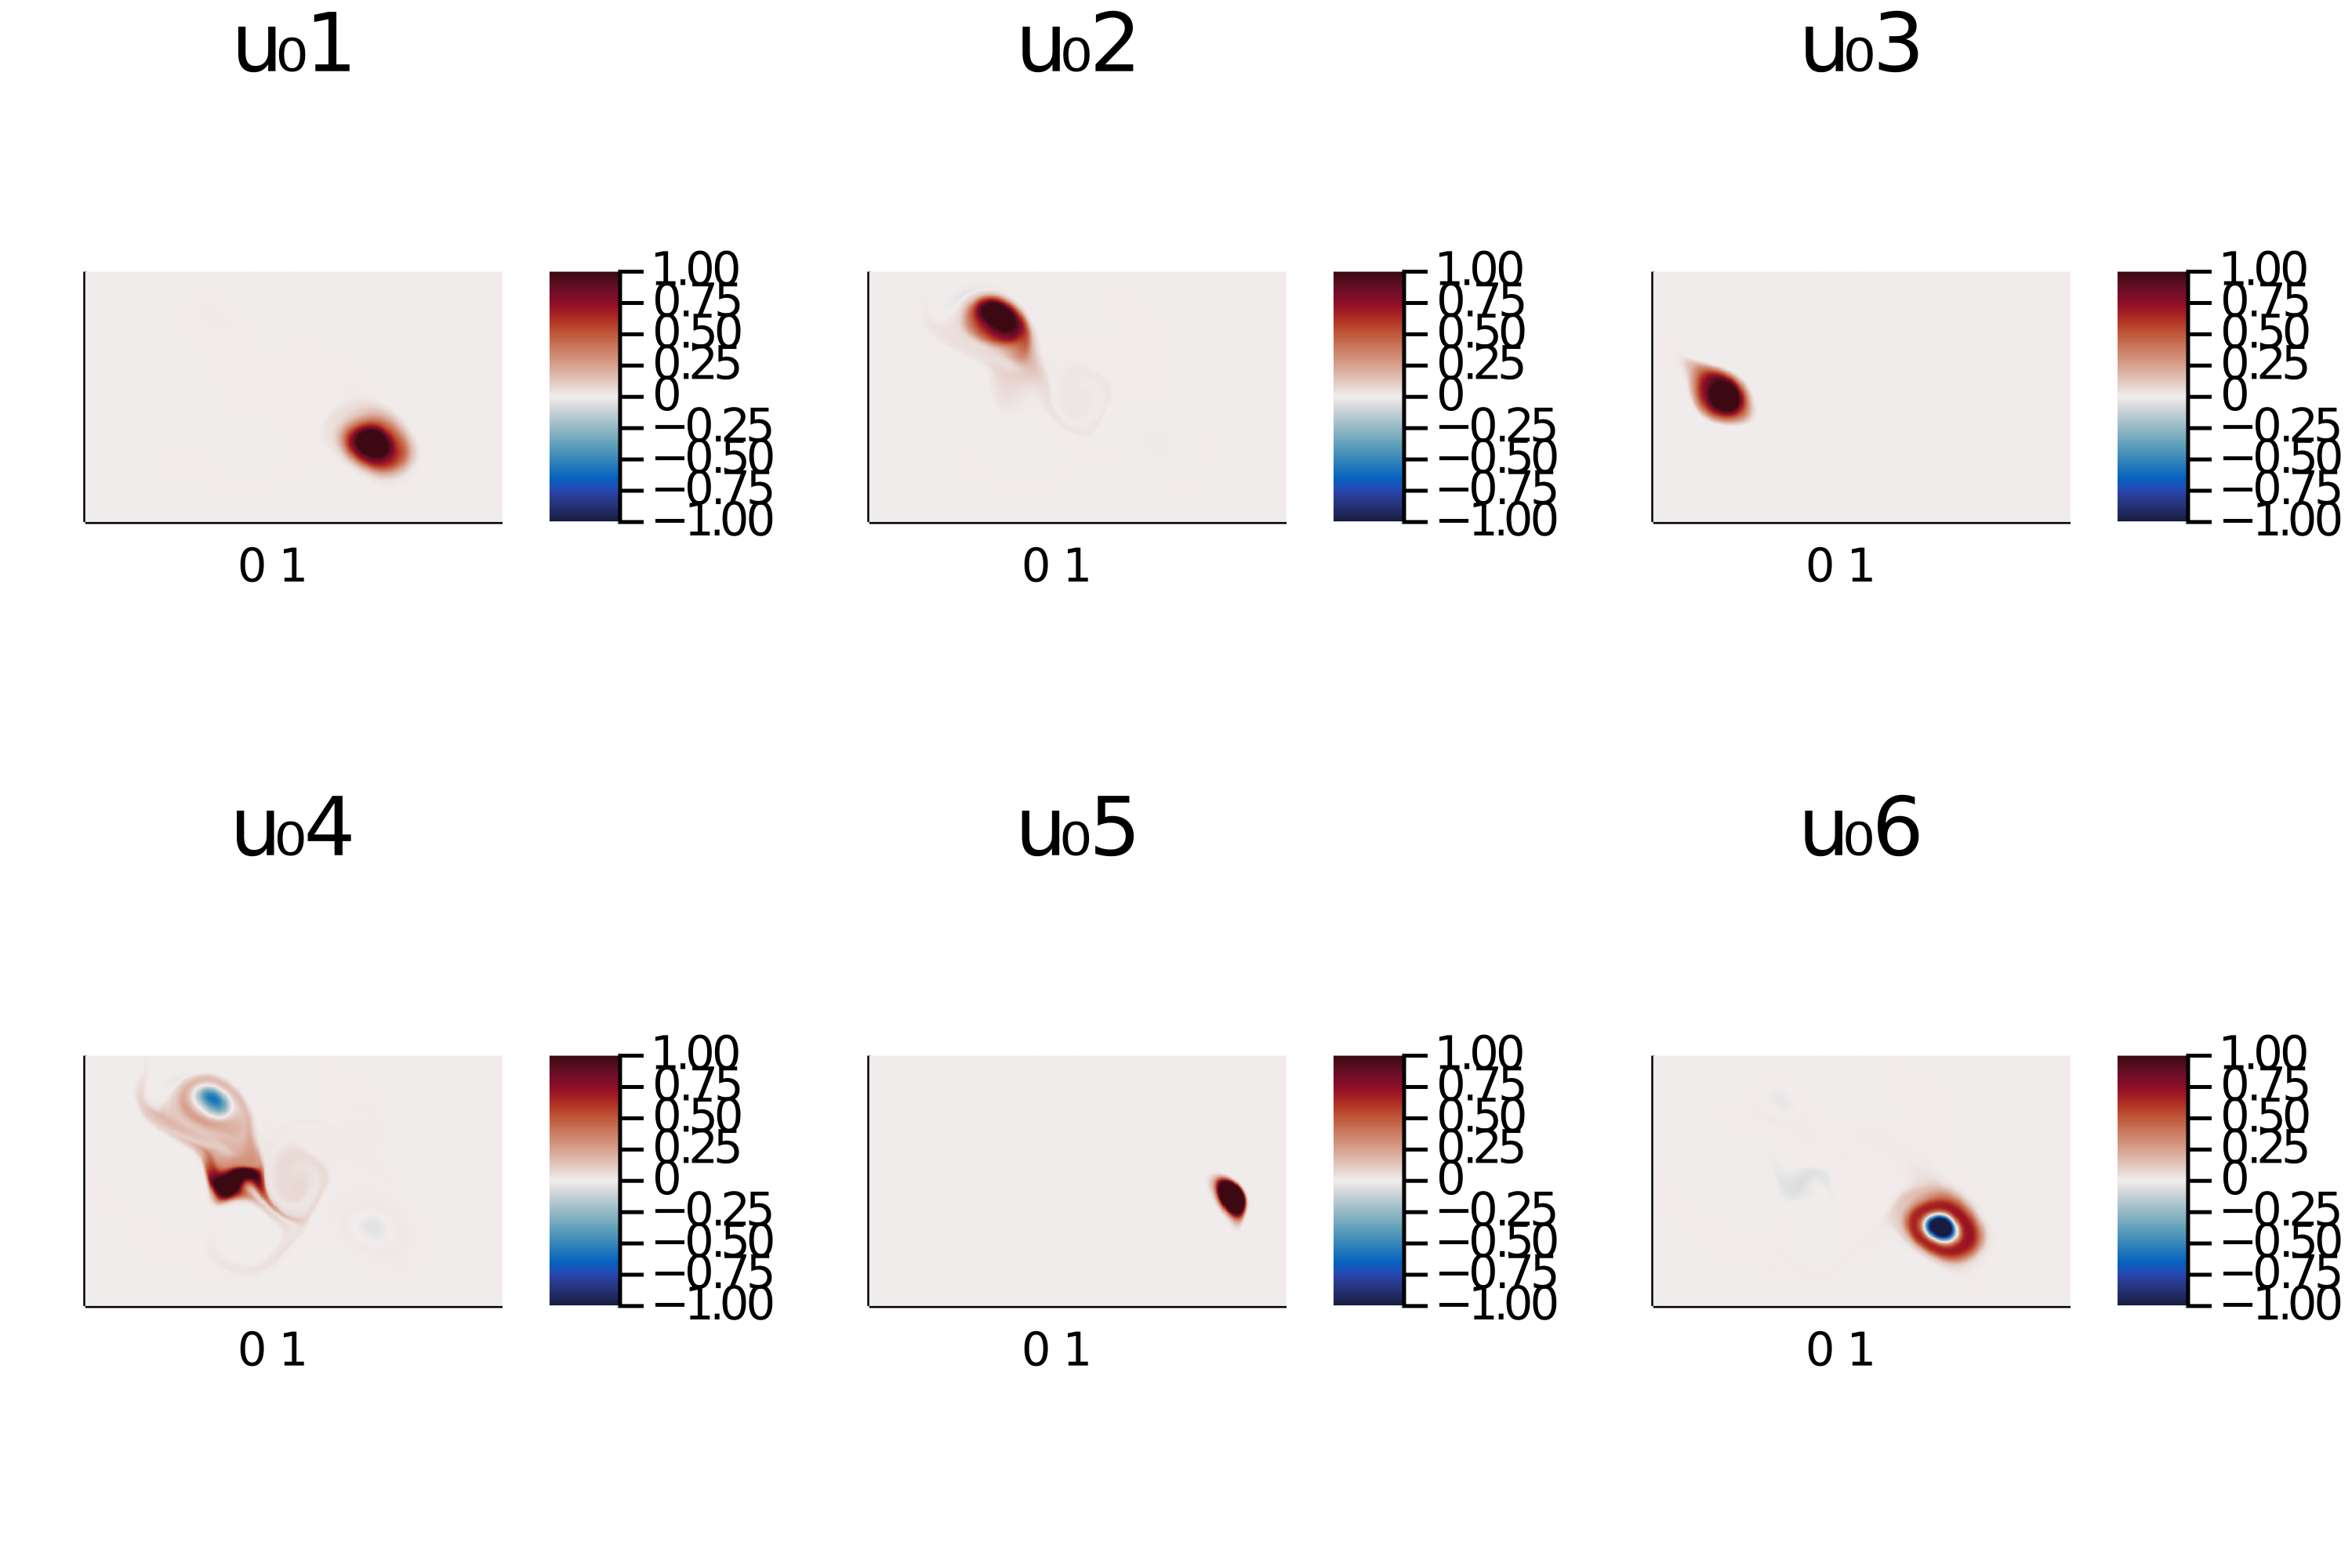

In [16]:
first         = plot_u(ctx, u₀s[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, u₀s[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, u₀s[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, u₀s[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, u₀s[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, u₀s[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

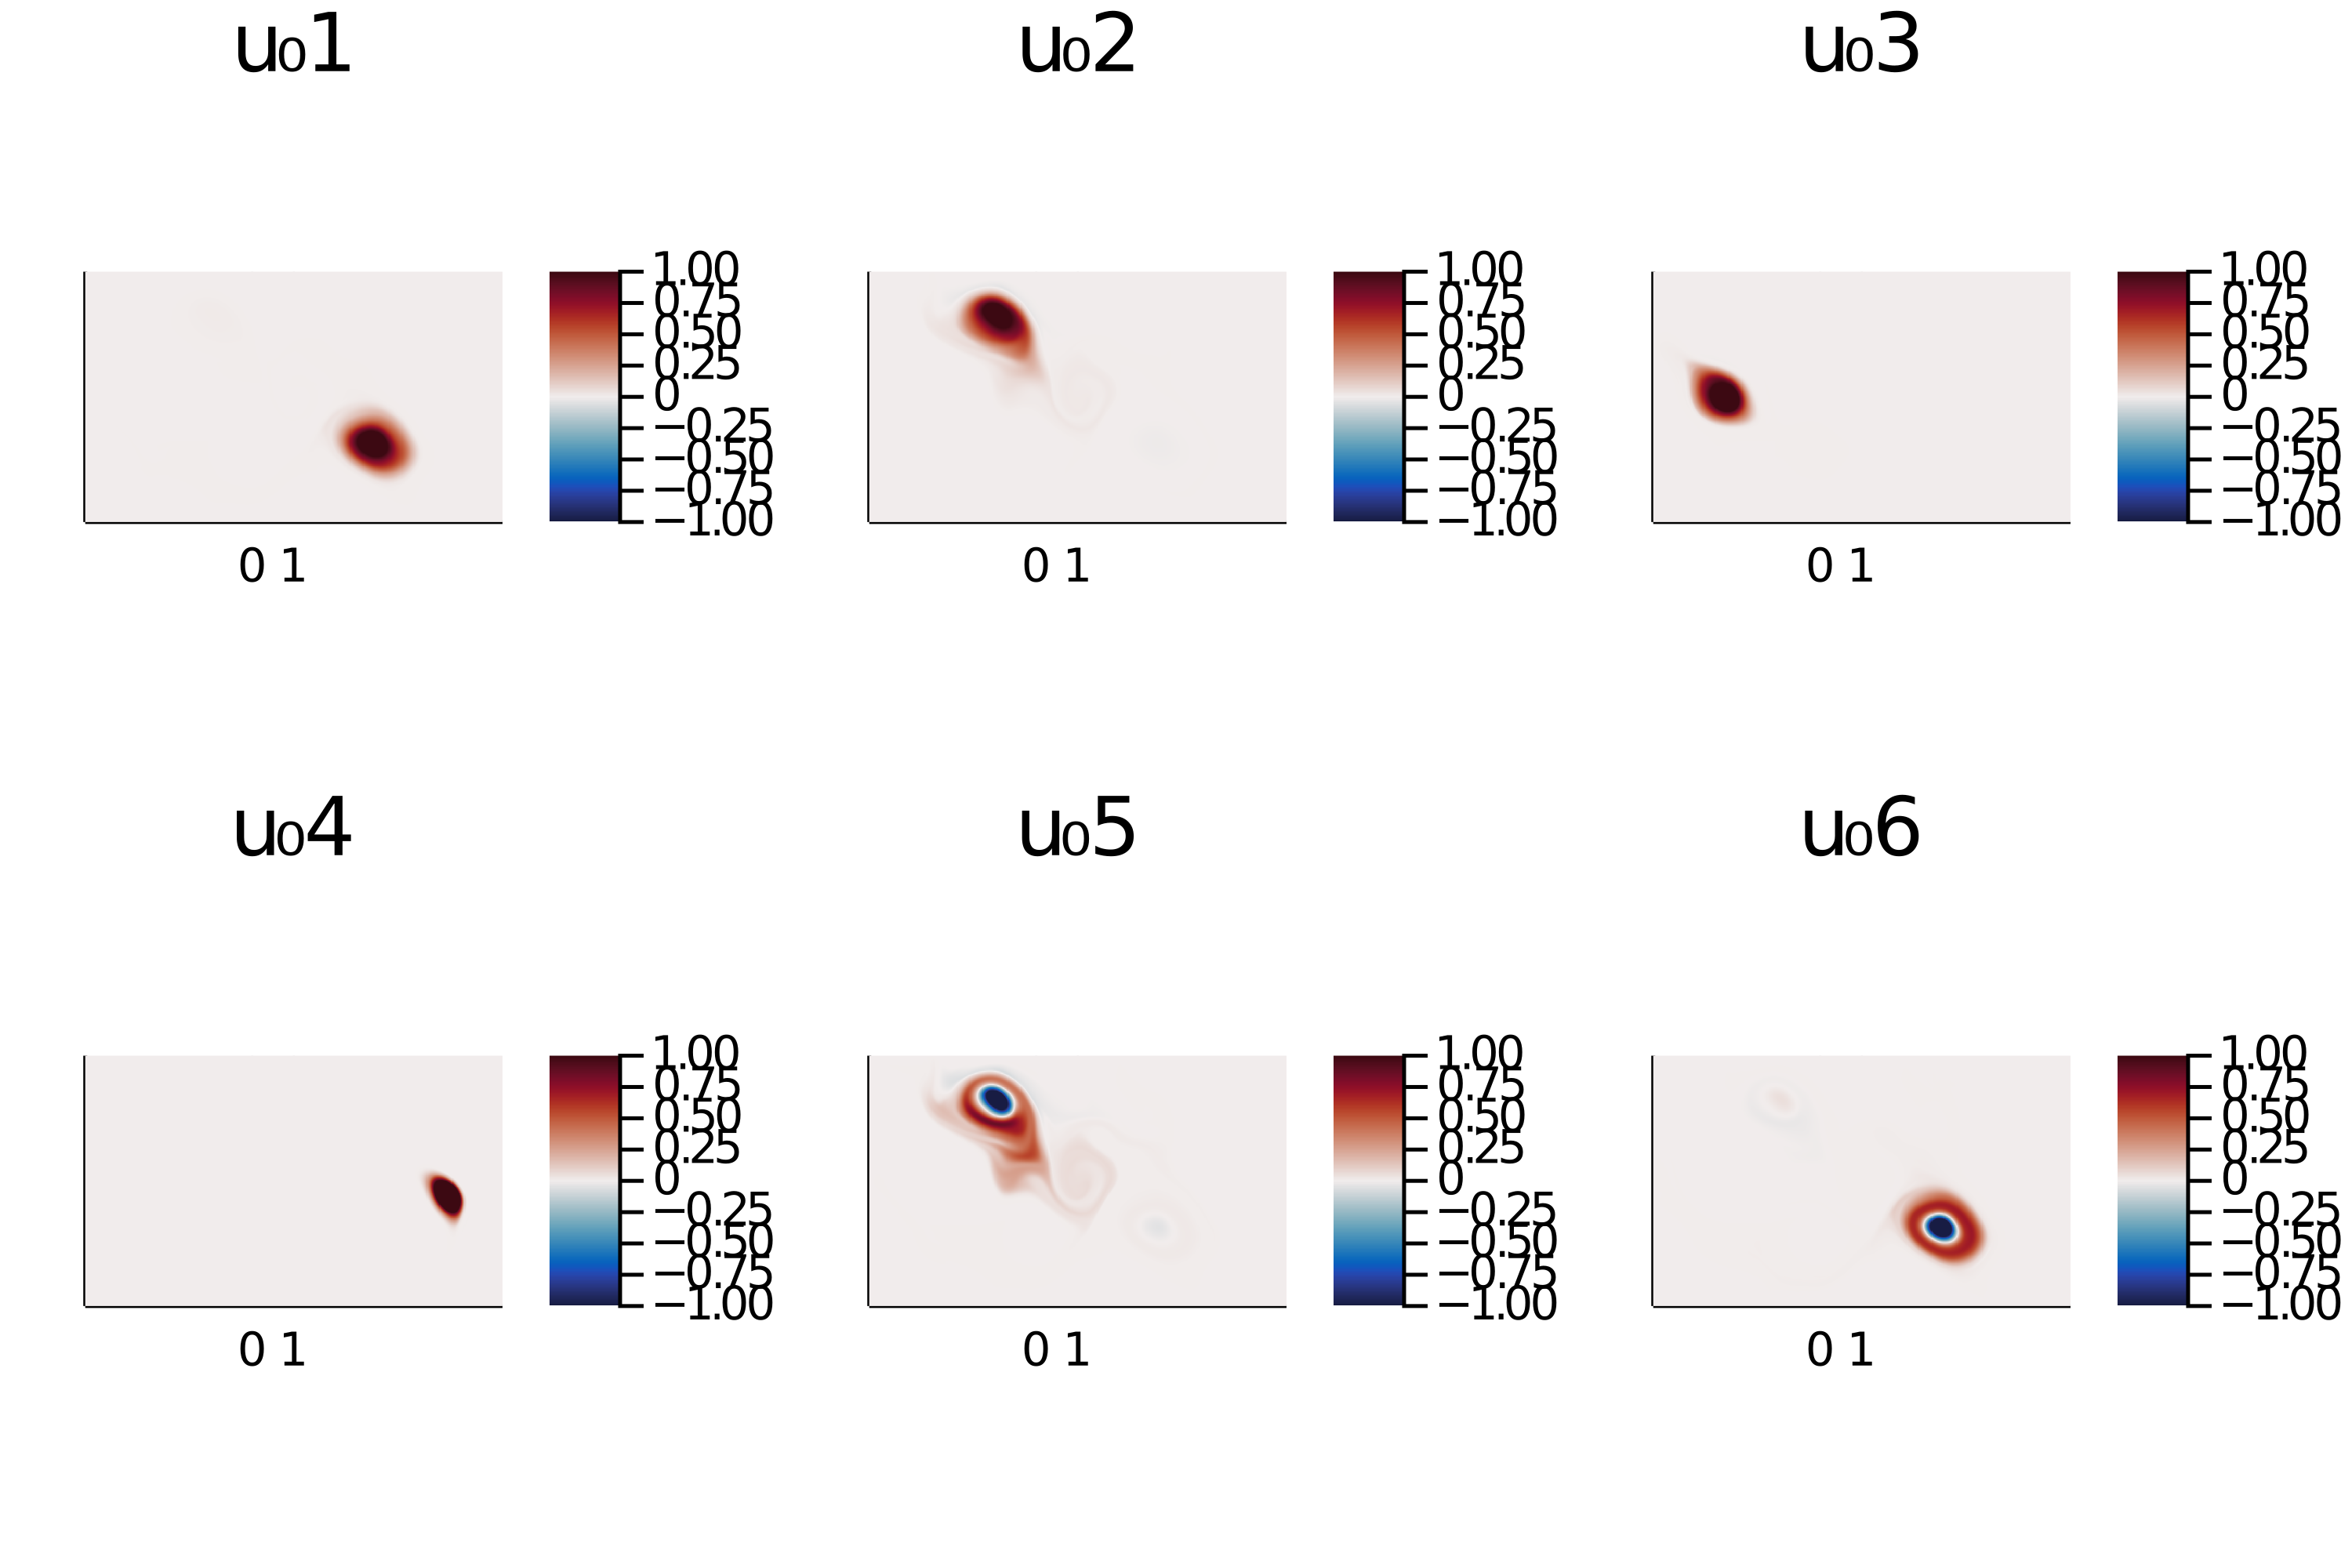

In [17]:
first         = plot_u(ctx, uϵs[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, uϵs[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, uϵs[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, uϵs[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, uϵs[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, uϵs[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

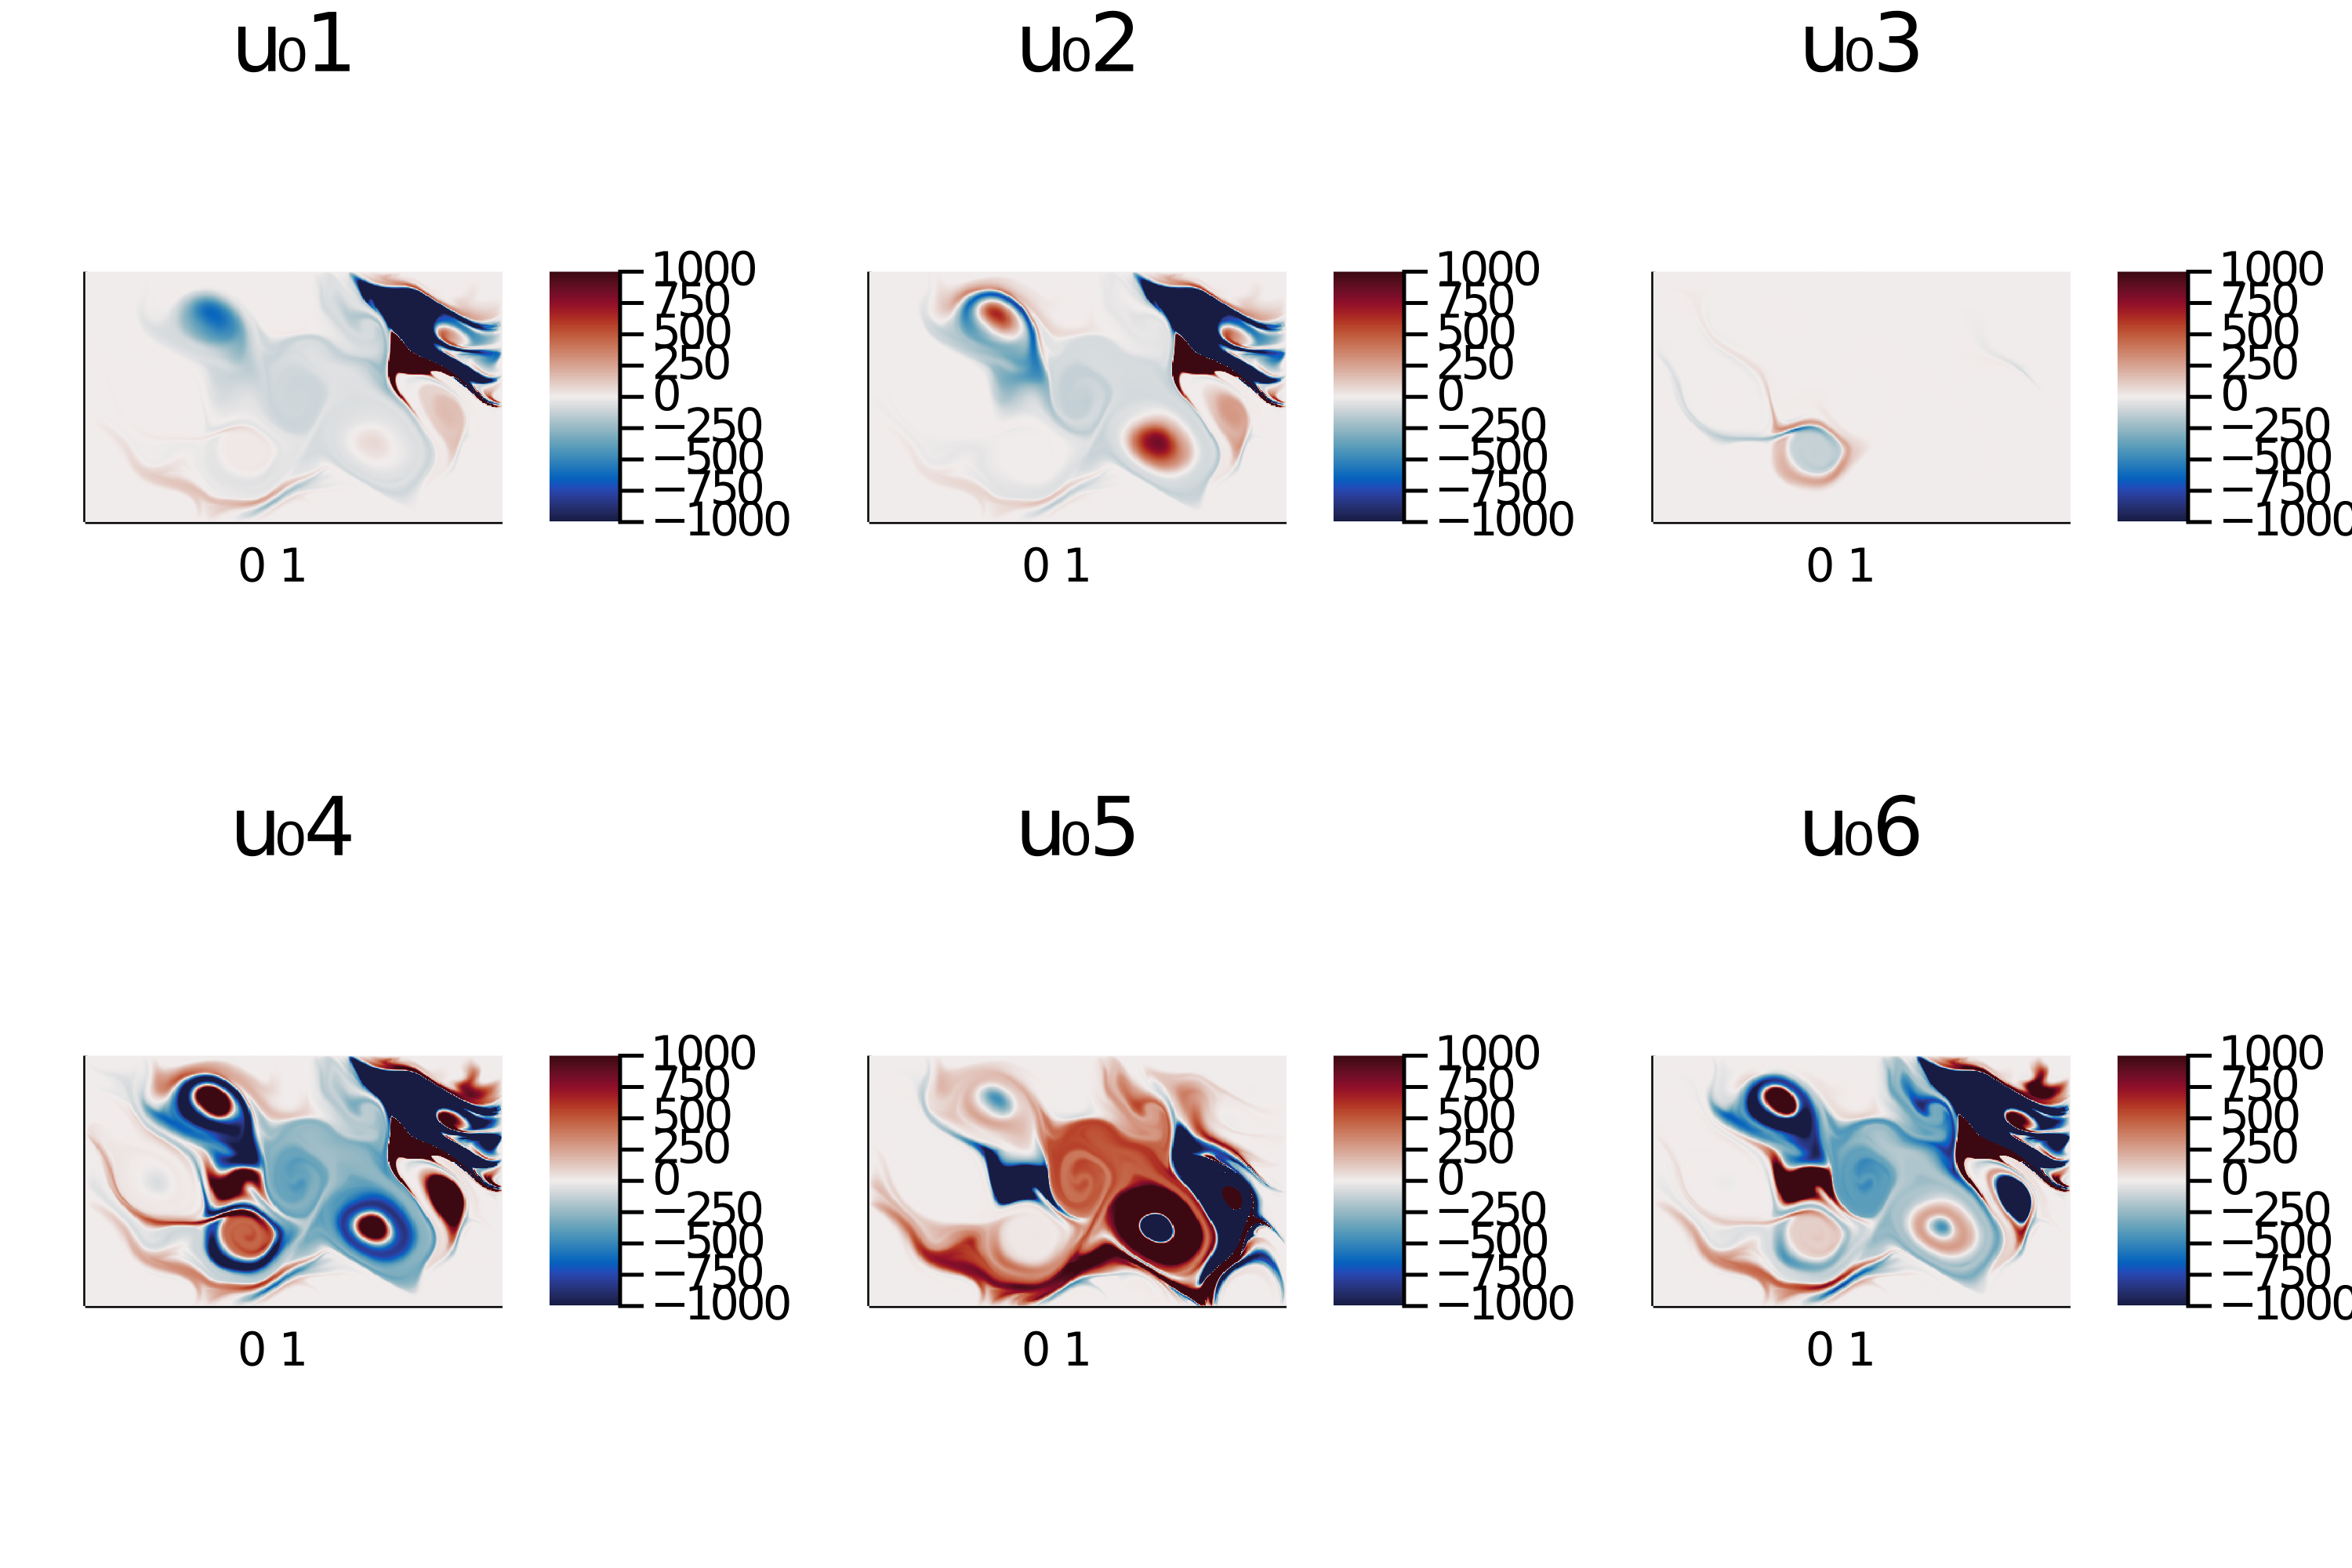

In [18]:
first         = plot_u(ctx, u_dots[1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, u_dots[2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, u_dots[3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, u_dots[4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, u_dots[5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, u_dots[6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

In [19]:
S = SEBA(u₀s)

148404×6 Array{Float64,2}:
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  ⋮                             ⋮
 -0.0  -0.0  -0.0   0.0   0.0   0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0   0.0  -0.0  -0.0  -0.0
  0.0  -0.0   0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0   0.0   0.0   0.0
 -0.0   0.0   0.0   0.0   0.0   0.0
 -0.0   0.0  -0.0   0.0   0.0   0.0
  0.0  -0.0   0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0

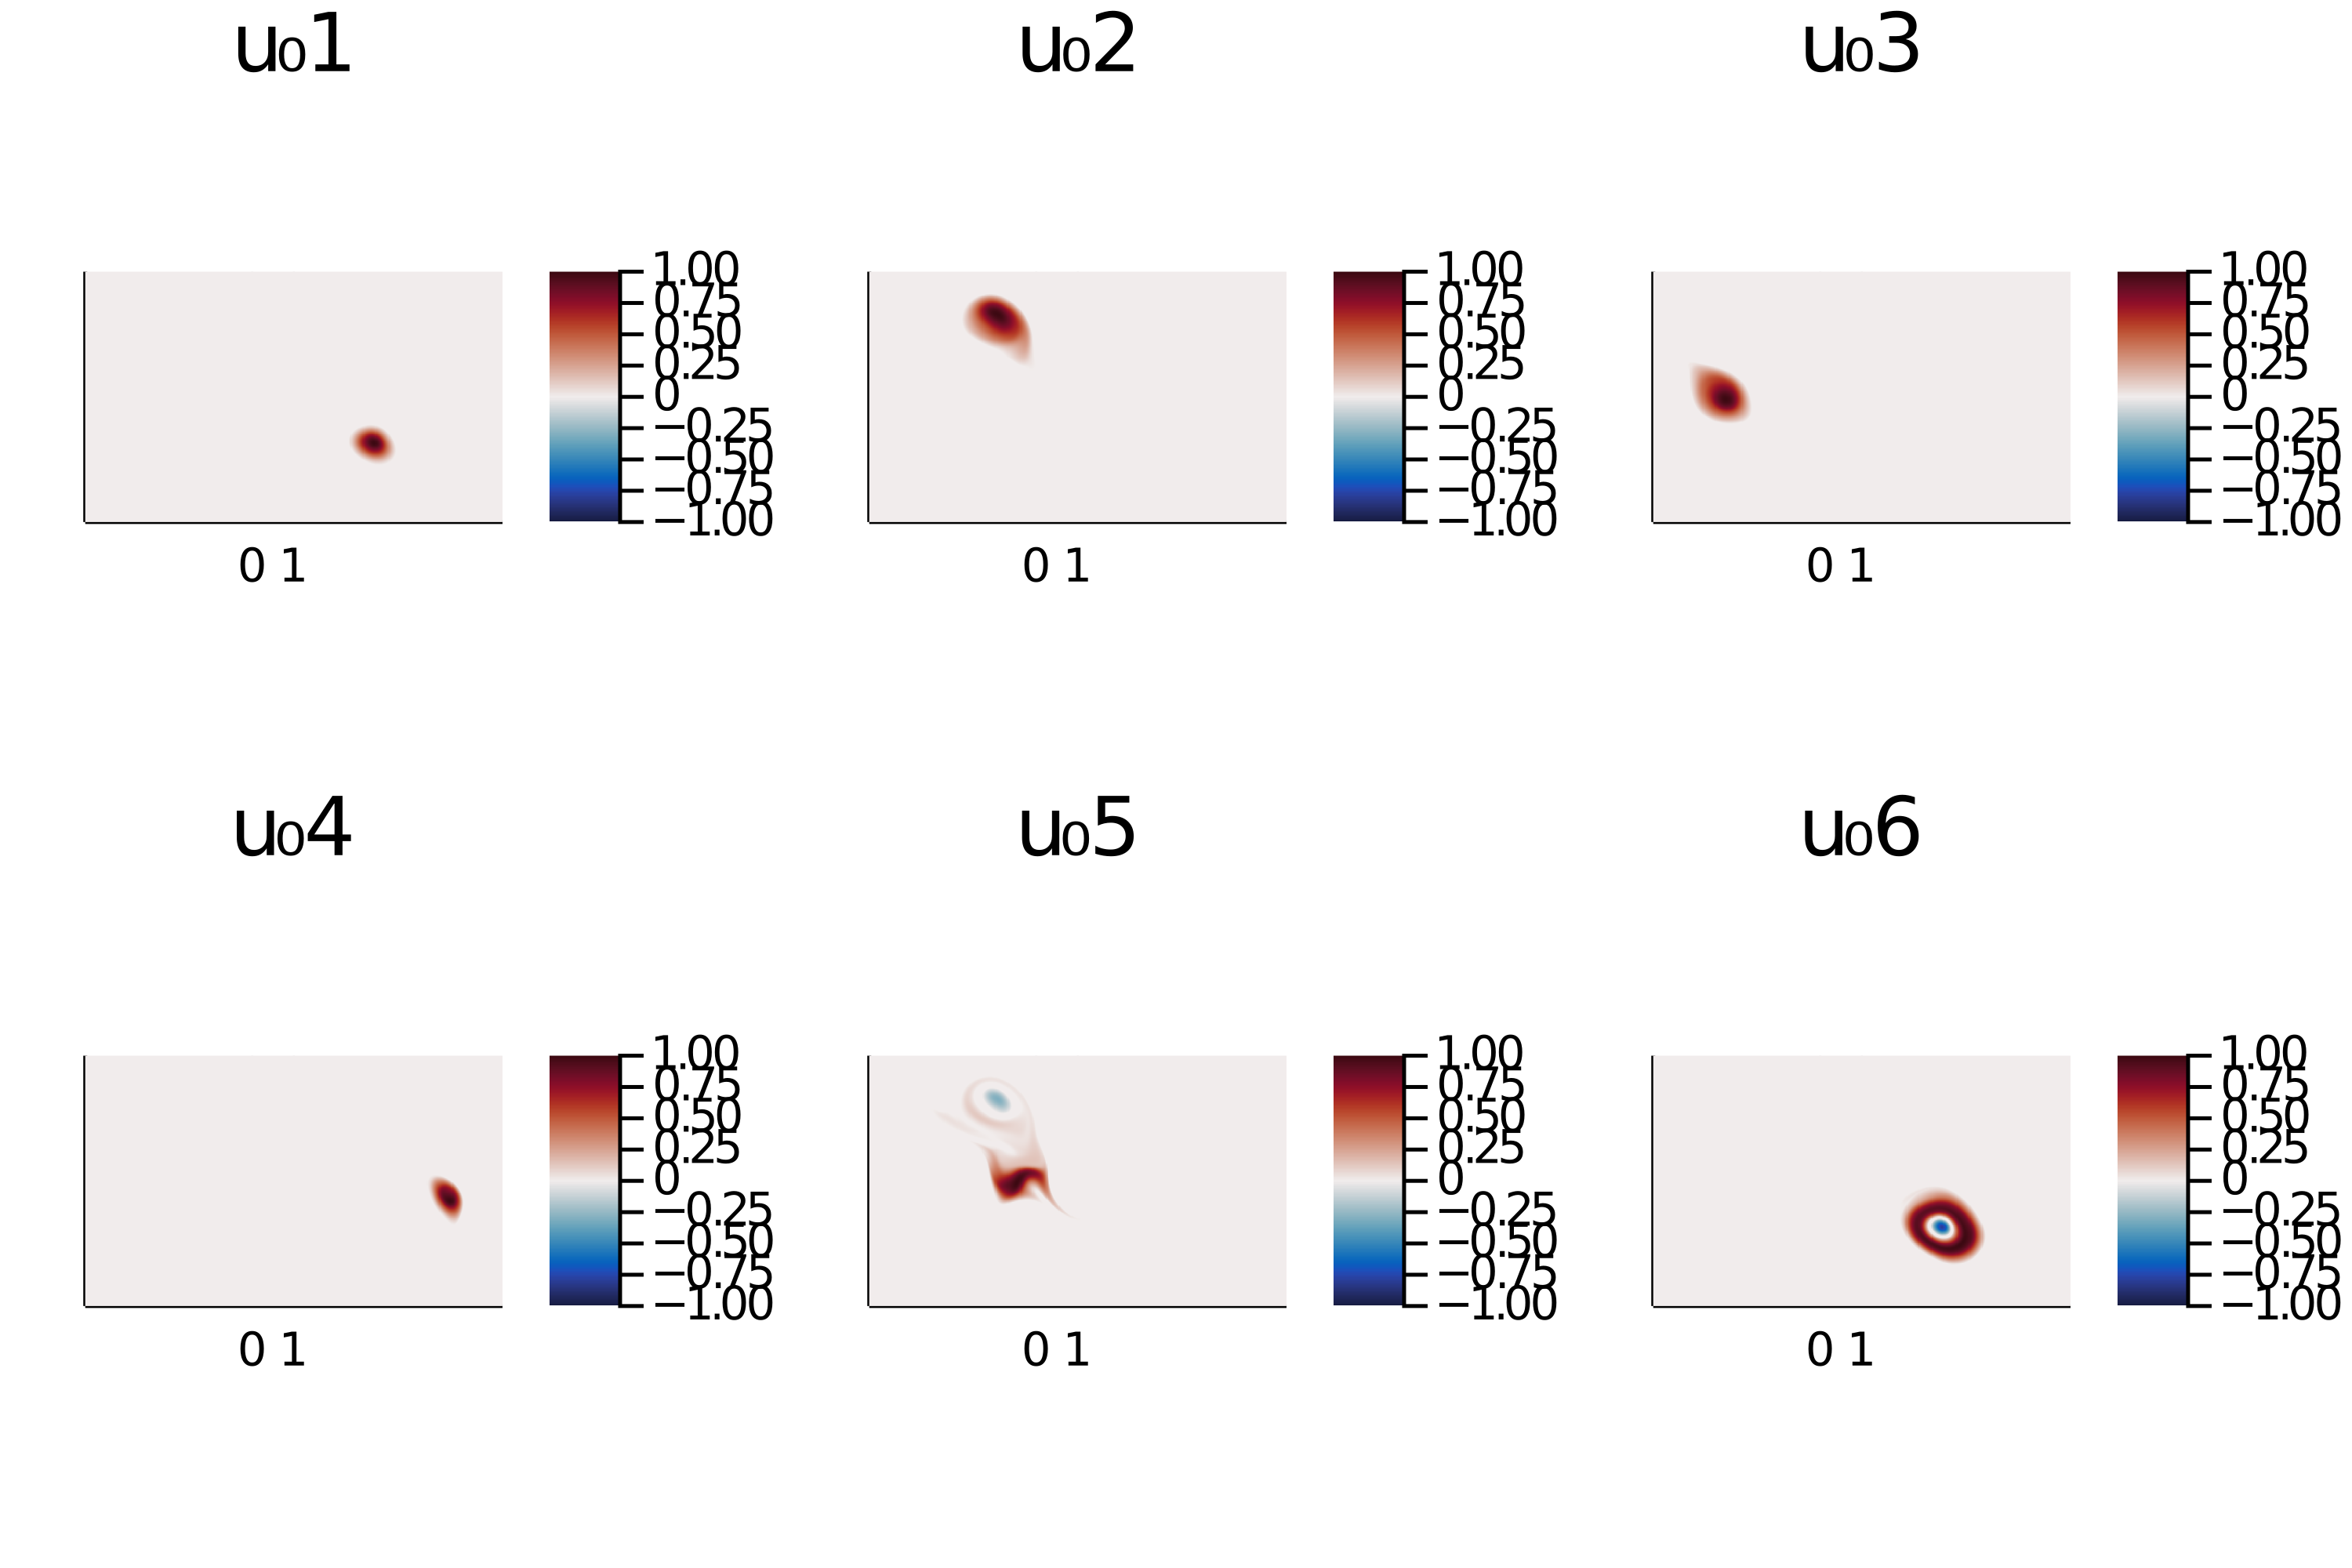

In [20]:
first         = plot_u(ctx, S[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, S[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, S[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, S[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, S[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, S[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)

In [21]:
Sϵ = SEBA(uϵs)

148404×6 Array{Float64,2}:
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  ⋮                             ⋮
 -0.0   0.0   0.0  -0.0   0.0   0.0
 -0.0   0.0   0.0  -0.0   0.0   0.0
  0.0   0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
 -0.0   0.0   0.0  -0.0   0.0   0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0   0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0   0.0  -0.0   0.0  -0.0  -0.0
  0.0   0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0   0.0  -0.0  -0.0

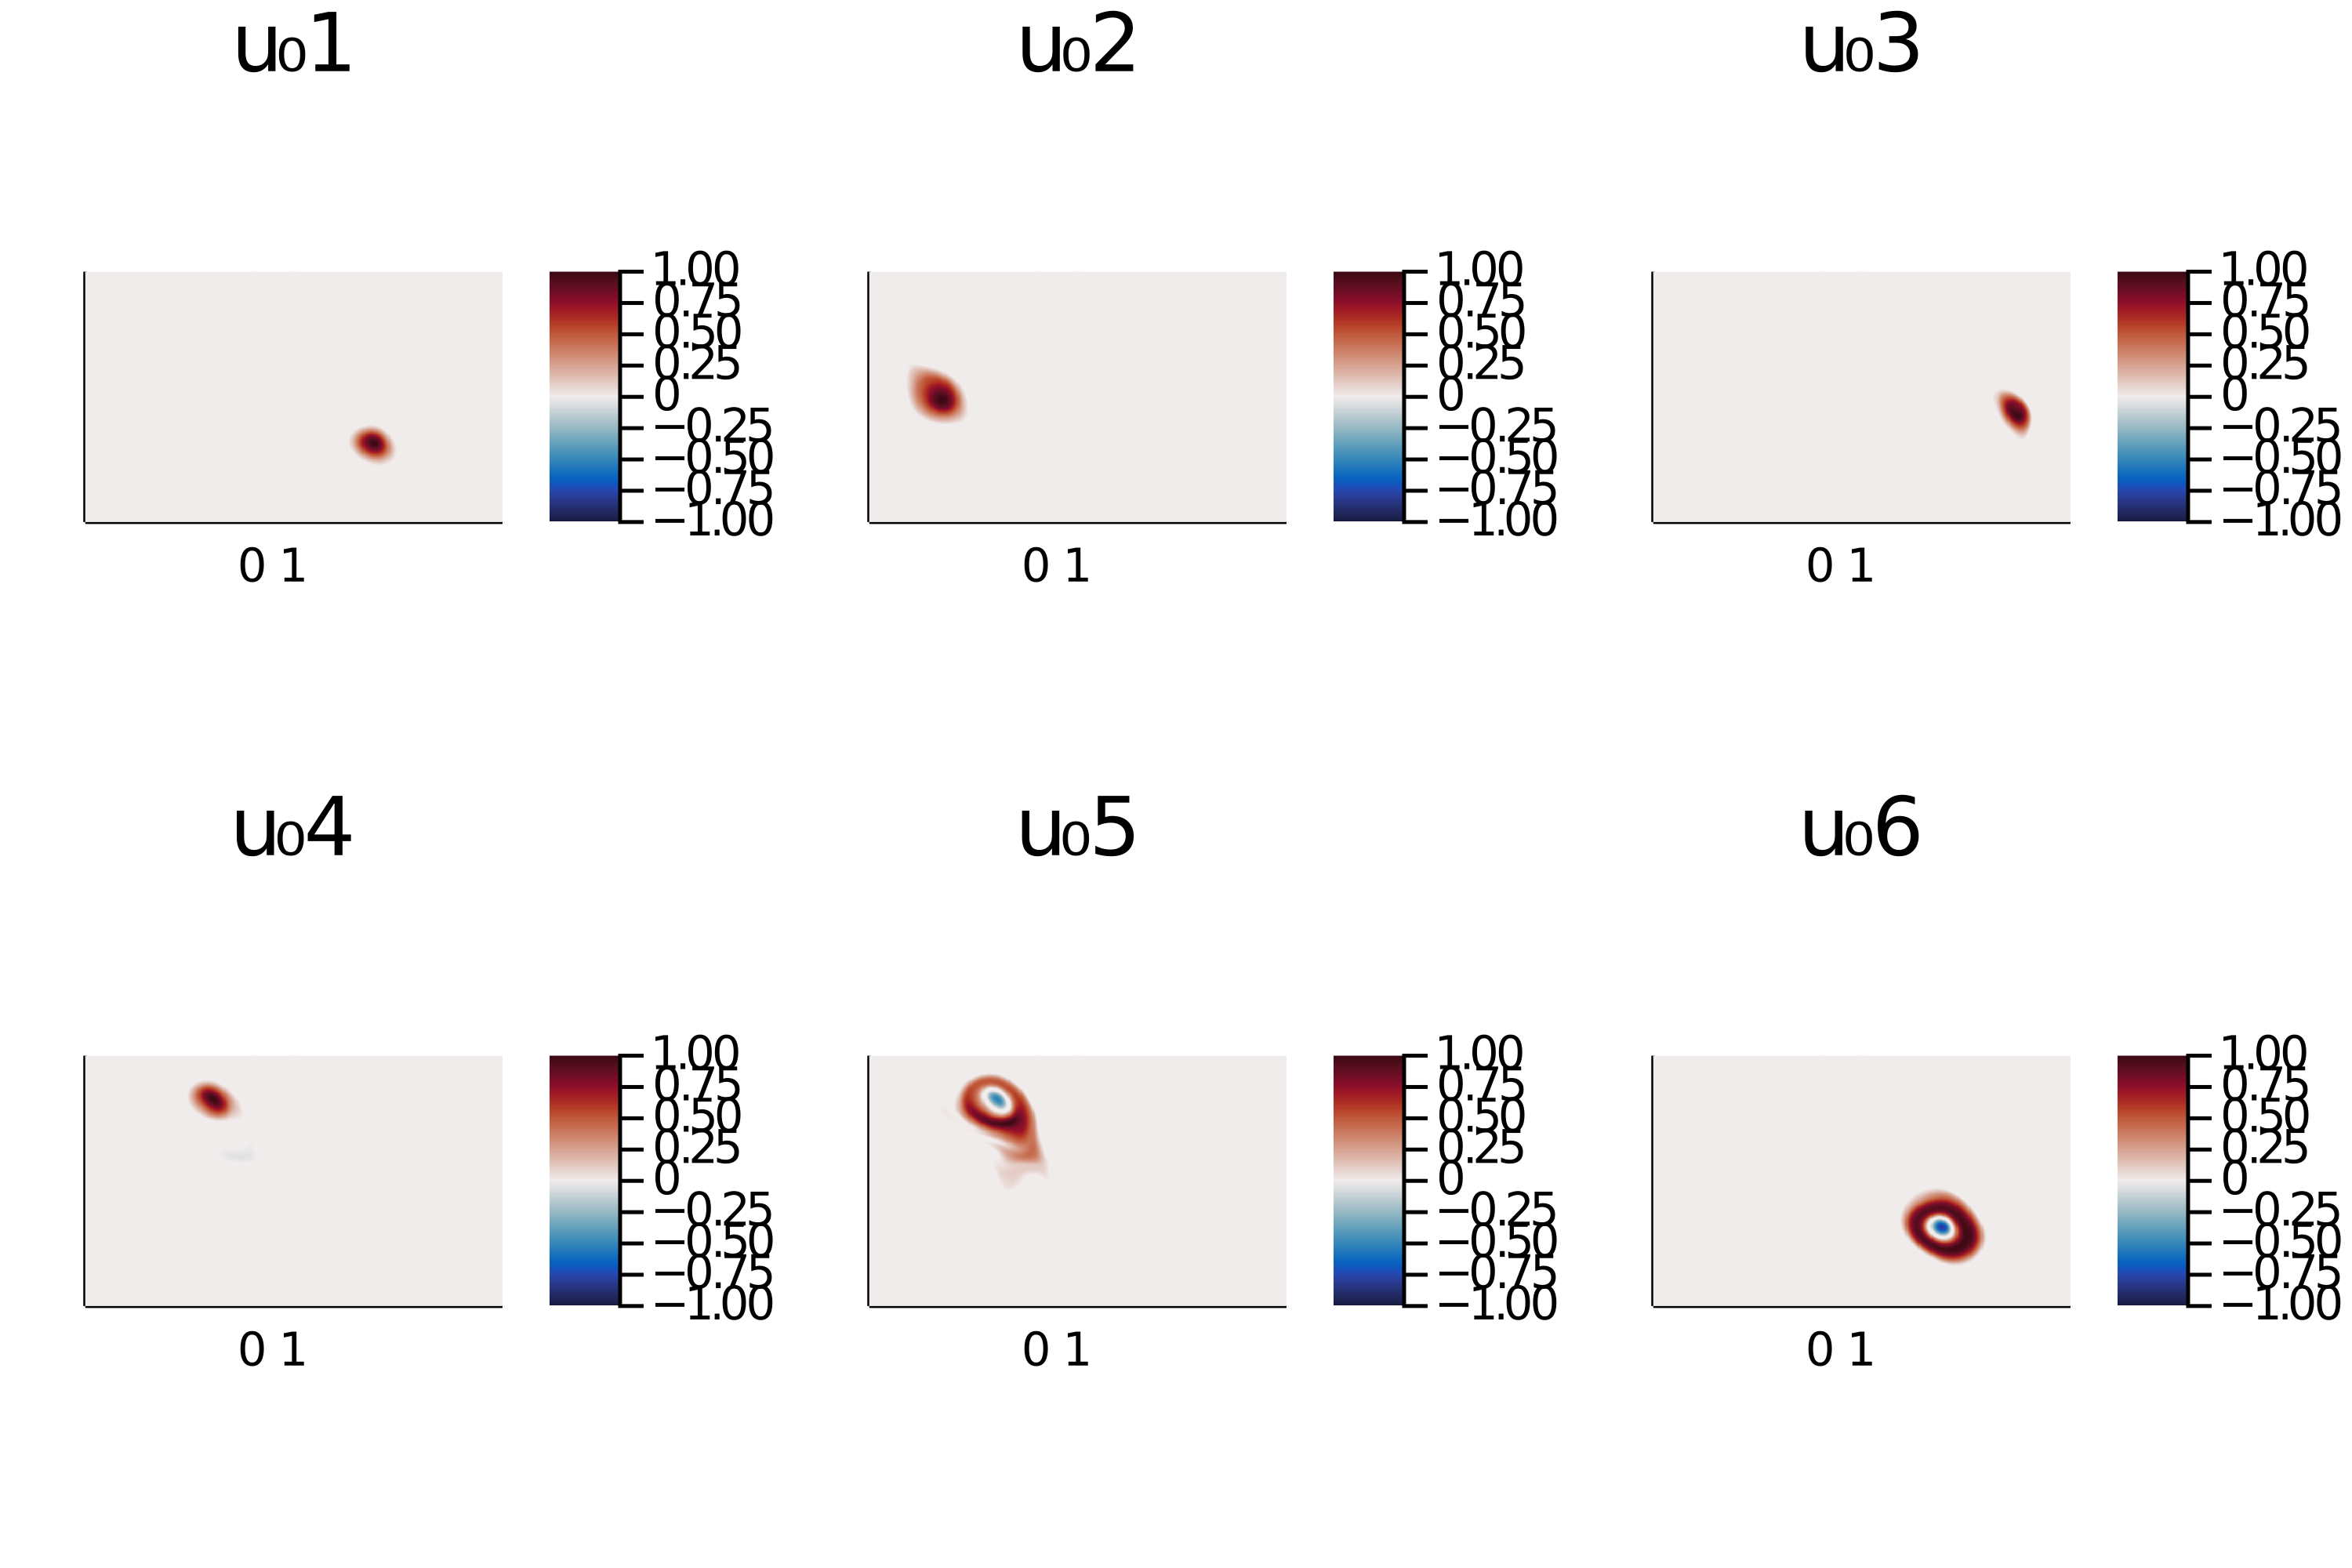

In [22]:
first         = plot_u(ctx, Sϵ[:,1],  grid_resolution, grid_resolution, title="u₀1", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
second        = plot_u(ctx, Sϵ[:,2],  grid_resolution, grid_resolution, title="u₀2", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
third         = plot_u(ctx, Sϵ[:,3],  grid_resolution, grid_resolution, title="u₀3", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
forth         = plot_u(ctx, Sϵ[:,4],  grid_resolution, grid_resolution, title="u₀4", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
fifth         = plot_u(ctx, Sϵ[:,5],  grid_resolution, grid_resolution, title="u₀5", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
sixth         = plot_u(ctx, Sϵ[:,6],  grid_resolution, grid_resolution, title="u₀6", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(first,second,third,forth,fifth,sixth, fmt=:png, dpi=500)